# Duygu Analizi Modeli Eğitimi

Bu notebook'ta FER2013 veri setini kullanarak duygu tanıma modelimizi eğiteceğiz.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cwd = os.getcwd()
print("Geçerli çalışma dizini:", cwd)



Geçerli çalışma dizini: C:\Users\ymete\Desktop\Kodlarim\bitirme1\notebooks


## Veri Setinin Hazırlanması

FER2013 veri setini yükleyip ön işleme yapacağız.


In [28]:
def load_images_from_directory(directory):
    images = []
    labels = []
    emotion_map = {
        'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
        'sad': 4, 'surprise': 5, 'neutral': 6
    }
    
    for emotion in emotion_map.keys():
        path = os.path.join(directory, emotion)
        if os.path.exists(path):
            for img_file in os.listdir(path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(path, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (48, 48))
                        img = img.astype('float32') / 255.0
                        images.append(img)
                        label = [0] * len(emotion_map)
                        label[emotion_map[emotion]] = 1
                        labels.append(label)
    
    return np.array(images), np.array(labels)

# Eğitim ve test verilerini yükle
print("Eğitim verilerini yüklüyorum...")
x_train, y_train = load_images_from_directory('../data/raw/train')

print("Test verilerini yüklüyorum...")
x_test, y_test = load_images_from_directory('../data/raw/test')

# Görüntüleri doğru formata dönüştür
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"Eğitim seti boyutu: {x_train.shape}")
print(f"Test seti boyutu: {x_test.shape}")


Eğitim verilerini yüklüyorum...
Test verilerini yüklüyorum...
Eğitim seti boyutu: (28709, 48, 48, 1)
Test seti boyutu: (7178, 48, 48, 1)


In [30]:
def create_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)
    
    # İlk konvolüsyon bloğu
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # İkinci konvolüsyon bloğu
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Üçüncü konvolüsyon bloğu
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Yoğun katmanlar
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Modeli oluştur ve derle
model = create_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model özetini göster
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape               ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)         │ (None, 48, 48, 1)          │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ conv2d_6 (Conv2D)                  │ (None, 48, 48, 64)         │            640 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ batch_normalization_7              │ (None, 48, 48, 64)         │            256 │
│ (BatchNormalization)               │                            │                │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ conv2d_7 (Conv2D)                  │ (None, 48, 48, 64)         │         36,928 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ batch_normalization_8              │ (None, 48, 48, 64)         │            256 │
│ (BatchNormalization)               │                            │                │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ max_pooling2d_3 (MaxPooling2D)     │ (None, 24, 24, 64)         │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout_4 (Dropout)                │ (None, 24, 24, 64)         │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ conv2d_8 (Conv2D)                  │ (None, 24, 24, 128)        │         73,856 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ batch_normalization_9              │ (None, 24, 24, 128)        │            512 │
│ (BatchNormalization)               │                            │                │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ conv2d_9 (Conv2D)                  │ (None, 24, 24, 128)        │        147,584 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ batch_normalization_10             │ (None, 24, 24, 128)        │            512 │
│ (BatchNormalization)               │                            │                │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ max_pooling2d_4 (MaxPooling2D)     │ (None, 12, 12, 128)        │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout_5 (Dropout)                │ (None, 12, 12, 128)        │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ conv2d_10 (Conv2D)                 │ (None, 12, 12, 256)        │        295,168 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ batch_normalization_11             │ (None, 12, 12, 256)        │          1,024 │
│ (BatchNormalization)               │                            │                │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ conv2d_11 (Conv2D)                 │ (None, 12, 12, 256)        │        590,080 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ batch_normalization_12             │ (None, 12, 12, 256)        │          1,024 │
│ (BatchNormalization)               │                            │                │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ max_pooling2d_5 (MaxPooling2D)     │ (None, 6, 6, 256)          │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout_6 (Dropout)                │ (None, 6, 6, 256)          │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ fla

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Model Mimarisi

CNN tabanlı bir model oluşturacağız.


In [32]:
def create_model(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
## Veri Artırma ve Model Eğitimi


In [36]:
# Veri artırma
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Model eğitimi
batch_size = 64
epochs = 50

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=epochs,
    steps_per_epoch=len(x_train) // batch_size
)


C:\Users\ymete\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 297s 653ms/step - accuracy: 0.2038 - loss: 2.4611 - val_accuracy: 0.2171 - val_loss: 2.0302
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:13 566ms/step - accuracy: 0.2656 - loss: 2.0061

C:\Users\ymete\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.2656 - loss: 2.0061 - val_accuracy: 0.2421 - val_loss: 2.0426
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 259s 577ms/step - accuracy: 0.2836 - loss: 1.8235 - val_accuracy: 0.3979 - val_loss: 1.5509
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.4688 - loss: 1.4137 - val_accuracy: 0.3931 - val_loss: 1.5485
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 277s 617ms/step - accuracy: 0.4012 - loss: 1.5416 - val_accuracy: 0.4778 - val_loss: 1.3507
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4844 - loss: 1.2742 - val_accuracy: 0.4726 - val_loss: 1.3721
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 259s 577ms/step - accuracy: 0.4624 - loss: 1.3977 - val_accuracy: 0.5252 - val_loss: 1.2410
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5156 - loss: 1.2768 - val_accuracy: 0.5180 - val_loss: 1.2538
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 257s 574ms/step - accuracy: 0.5059 - loss: 1.2981 - val

In [38]:
## Eğitim Sonuçlarının Görselleştirilmesi


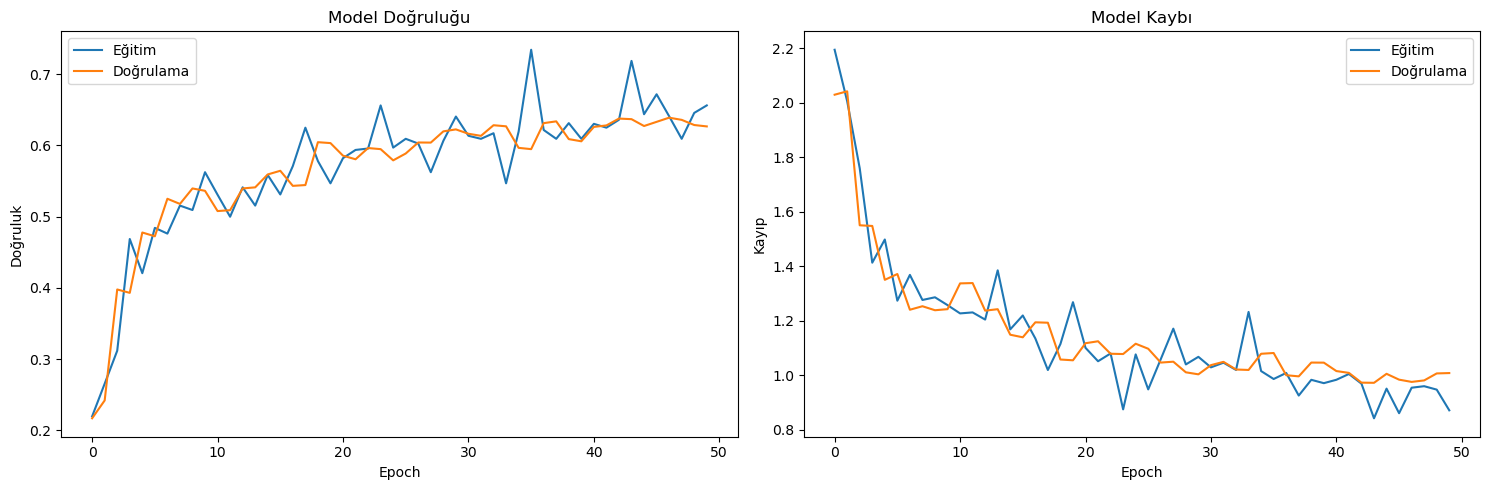

In [40]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Doğruluk grafiği
    ax1.plot(history.history['accuracy'], label='Eğitim')
    ax1.plot(history.history['val_accuracy'], label='Doğrulama')
    ax1.set_title('Model Doğruluğu')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Doğruluk')
    ax1.legend()
    
    # Kayıp grafiği
    ax2.plot(history.history['loss'], label='Eğitim')
    ax2.plot(history.history['val_loss'], label='Doğrulama')
    ax2.set_title('Model Kaybı')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Kayıp')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [42]:
## Modeli Kaydet


In [44]:
# Modeli kaydet
model.save('../data/models/emotion_model.h5')
print("Model başarıyla kaydedildi!")


Model başarıyla kaydedildi!
